In [24]:
import numpy as np, re, os
import time, pickle as pkl 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mlrose_hiive as mr
from mrcounter import RHCCounter

from test_harness import *


def show_iterations(filename):
    with open(filename, 'rb') as f:
        res = pkl.load(f)

        plt.figure()

        for algo in res:
            curves = res[algo]['curves']
            cv = get_curves(curves, algo)

            p50 = cv['p50']
            p33 = cv['p33']
            p66 = cv['p66']
            mean = np.array(cv['mean'])
            std = np.array(cv['std'])

            x = np.arange(1, len(p50)+1)
            p = plt.plot(x, mean, label=algo)
            plt.fill_between(x, mean-std , mean+std, alpha=0.2, color=p[-1].get_color())
        #plt.title('Effect of Restarts')
        plt.xlabel('Iterations', fontsize=12)
        plt.ylabel('Fitness Score', fontsize=12)
        plt.grid()
        plt.legend(fontsize=12)



In [2]:
def get_avg(res):
    d = {}
    for algo in res:
        r = res[algo]
        d[algo] = {'mean_score':  np.mean(r['fitness']), 'std_score':  np.std(r['fitness']),
                  'mean_eval': np.mean(r['evaluations']), 'std_eval': np.std(r['evaluations']),
                  'mean_iter': np.mean(r['iterations']), 'std_iter': np.std(r['iterations']),
                   'mean_time': np.mean(r['time']), 'std_time': np.std(r['time']),
                  }
    return d
        

In [3]:
def get_summary(trunk):
    d = {}
    for fname in os.listdir('.'):
        pattern = trunk + r"-(?P<n>\d+)\.pkl"
        match =  re.match(pattern, fname)
        if not match:
            continue

        N = int(match.group('n'))
        
        with open(fname, 'rb') as fin:
            res = pkl.load(fin)
            d[N] = get_avg(res)

    d2 = {}
    for k, v in d.items():
        for k2, v2 in v.items():
            item = d2.setdefault(k2, {})
            item[k] = v2
    return d2
    
    

In [4]:
def plot_scores(d, type):
    plt.figure()
    for algo, v in d.items():
        N = np.array(sorted(v.keys()))
        if type=='score':
            mean = np.array([v[x]['mean_score'] for x in N])
            std = np.array([v[x]['std_score'] for x in N])
        elif type=='eval':
            mean = np.array([v[x]['mean_eval'] for x in N])
            std = np.array([v[x]['std_eval'] for x in N])
        elif type=='iteration':
            mean = np.array([v[x]['mean_iter'] for x in N])
            std = np.array([v[x]['std_iter'] for x in N])
        else:
            assert 0

        p = plt.plot(N, mean, label=algo)
        plt.fill_between(N, mean-std , mean+std, alpha=0.2, color=p[-1].get_color())
    plt.legend()
    plt.grid()

def get_scores(d, type, algo):
    v = d[algo]
    
    N = np.array(sorted(v.keys()))
    if type=='score':
        mean = np.array([v[x]['mean_score'] for x in N])
        std = np.array([v[x]['std_score'] for x in N])
    elif type=='eval':
        mean = np.array([v[x]['mean_eval'] for x in N])/1000
        std = np.array([v[x]['std_eval'] for x in N])/1000
    elif type=='iteration':
        mean = np.array([v[x]['mean_iter'] for x in N])
        std = np.array([v[x]['std_iter'] for x in N])
    elif type=='time':
        mean = np.array([v[x]['mean_time'] for x in N])
        std = np.array([v[x]['std_time'] for x in N])

    else:
        print('unknown'. type)
        assert 0
    return N, mean, std

           

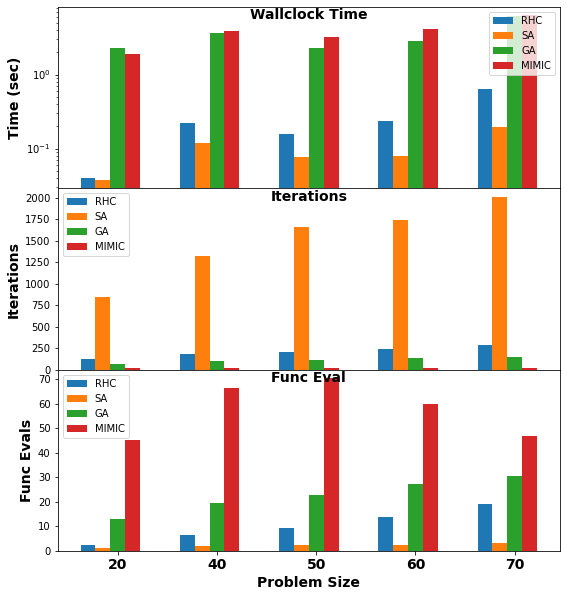

In [5]:
d2 = get_summary('4peaks')

charts = ['time', 'iteration', 'eval' ]
titles = ['Wallclock Time', 'Iterations', 'Func Eval']
ylabels = ['Time (sec)', 'Iterations', 'Func Evals']
algos = ['RHC', 'SA', 'GA', "MIMIC"]

fig = plt.figure(figsize=(9,10))
gs = gridspec.GridSpec(len(charts), 1, figure=fig)
gs.update(wspace=0.10, hspace=0)
width = 0.15

ax = None
for ich, chart in enumerate(charts):
    if ax is None:
        ax = ax1 = fig.add_subplot(gs[ich])
    else:
        ax1 = fig.add_subplot(gs[ich], sharex=ax)
        
    
    for ialgo, algo in enumerate(algos):
        n, b1, _ = get_scores(d2, chart, algo)
        x = np.arange(len(b1))
        ax1.bar(x+ialgo*width, b1  ,width=width, alpha=1,  label=algo)
        if ich==0:
            ax1.set_yscale('log')
    ax1.set_xticks(x+2*width)
    
    ax1.legend()
    ax1.set_title(titles[ich], y=0.9, fontweight='bold', fontsize=14)
    ax1.set_ylabel(ylabels[ich], fontweight='bold', fontsize=14)
ax1.set_xlabel('Problem Size', fontweight='bold', fontsize=14)
ax1.set_xticklabels(n, fontsize=14, fontweight='bold')
fig.show()
    

In [6]:
def make_composite_chart(d2):
    charts = ['score', 'time', 'iteration', 'eval' ]
    titles = ['Mean Fitness Score', 'Wallclock Time', 'Iterations', 'Func Eval']
    ylabels = ['Score', 'Time (sec)', 'Iterations', 'Func Evals $\times10^3$']
    algos = ['RHC', 'SA', 'GA', "MIMIC"]

    fig = plt.figure(figsize=(9,10))
    gs = gridspec.GridSpec(len(charts), 1, figure=fig)
    gs.update(wspace=0.10, hspace=0)
    width = 0.15

    ax = None
    for ich, chart in enumerate(charts):
        if ax is None:
            ax = ax1 = fig.add_subplot(gs[ich])
        else:
            ax1 = fig.add_subplot(gs[ich], sharex=ax)
        for ialgo, algo in enumerate(algos):
            n, b1, err = get_scores(d2, chart, algo)
            x = np.arange(len(b1))
            p=ax1.plot(n, b1, label=algo, marker='x')
            ax1.fill_between(n, b1-err , b1+err, alpha=0.1, color=p[-1].get_color())
            ax1.grid(True)


        ax1.set_title(titles[ich], y=0.8, fontweight='bold', fontsize=14)
        ax1.set_ylabel(ylabels[ich], fontweight='bold', fontsize=13)
        ax1.legend(fancybox=True, framealpha=0, loc='best')

    ax1.set_xlabel('Problem Size', fontweight='bold', fontsize=13)
    
    

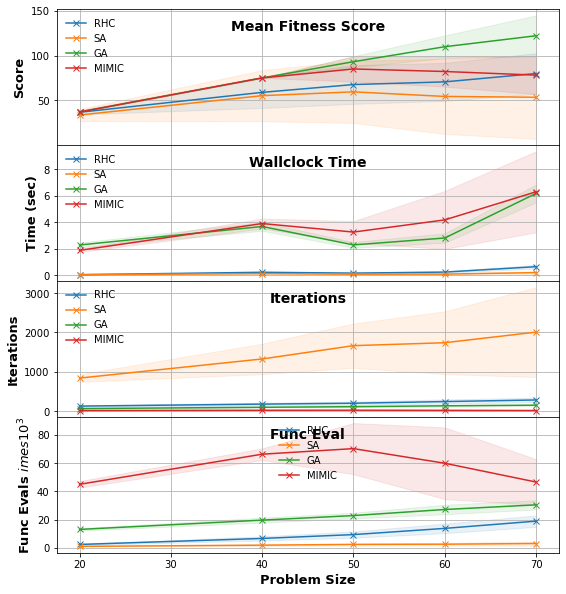

In [7]:
d2 = get_summary('4peaks')
make_composite_chart(d2)
plt.savefig('fp-composite.pdf')

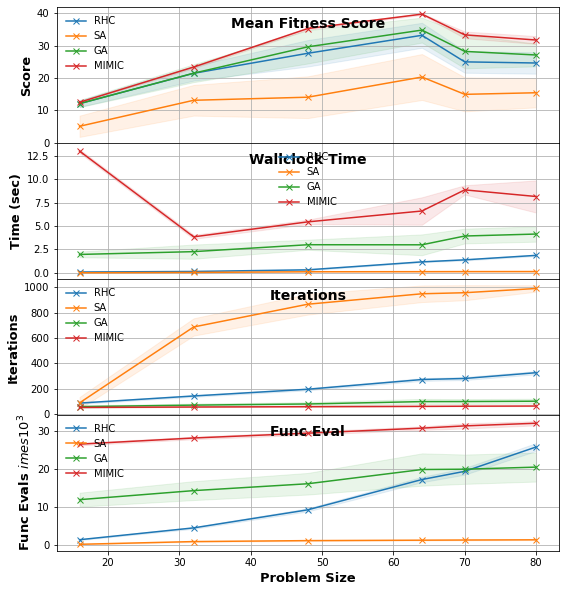

In [8]:
d2 = get_summary('li')
make_composite_chart(d2)
plt.savefig('li-composite.pdf')

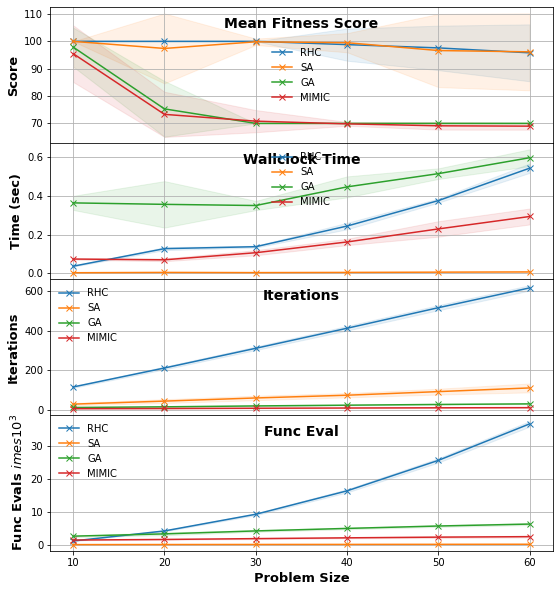

In [9]:
d2 = get_summary('tr')
make_composite_chart(d2)
plt.savefig('tr-composite.pdf')

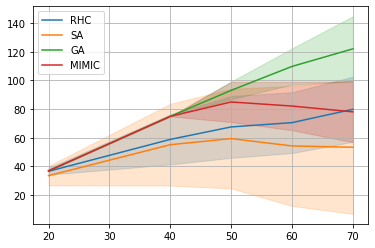

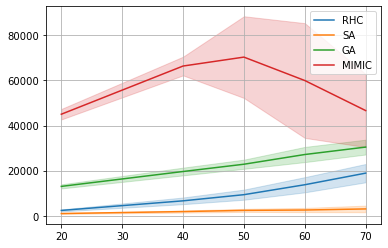

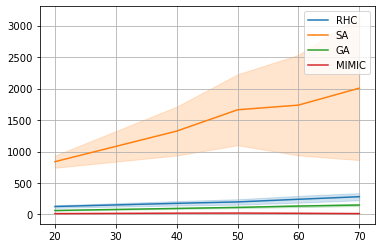

In [10]:
d2 = get_summary('4peaks')

plot_scores(d2, 'score')    

plt.savefig('fp-sscore.pdf')

plot_scores(d2, 'eval')    
plt.savefig('fp-seval.pdf')

plot_scores(d2, 'iteration')    
plt.savefig('fp-siter.pdf')


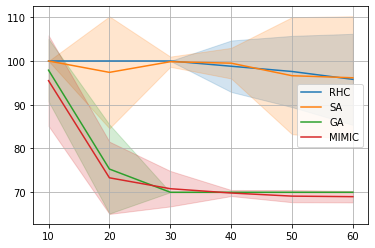

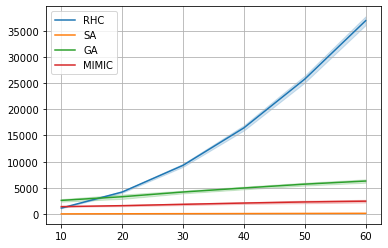

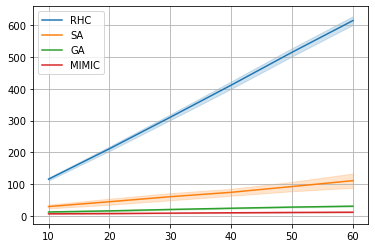

In [11]:
d2 = get_summary('tr')

plot_scores(d2, 'score')    
plt.savefig('tr-sscore.pdf')

plot_scores(d2, 'eval')    
plt.savefig('tr-seval.pdf')

plot_scores(d2, 'iteration')    
plt.savefig('tr-siter.pdf')

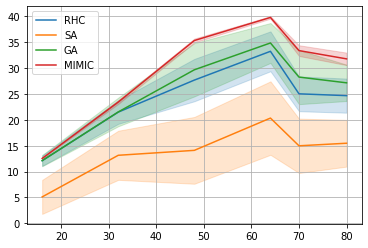

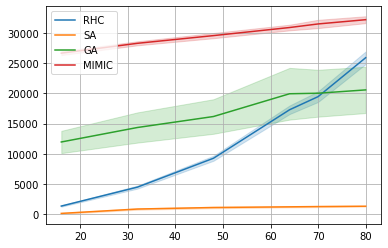

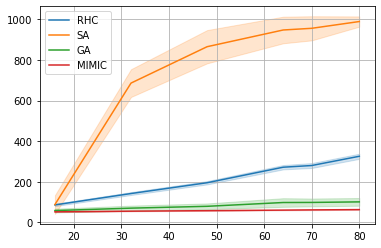

In [12]:
d2 = get_summary('li')
plot_scores(d2, 'score')    
plt.savefig('li-sscore.pdf')

plot_scores(d2, 'eval')    
plt.savefig('li-seval.pdf')

plot_scores(d2, 'iteration')    
plt.savefig('li-siter.pdf')


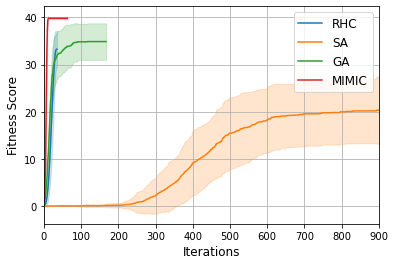

In [29]:
show_iterations('li-64.pkl')
plt.savefig('li-summ.pdf')

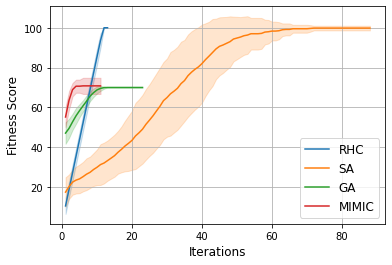

In [14]:
show_iterations('tr-30.pkl')
plt.savefig('tr-summ.pdf')

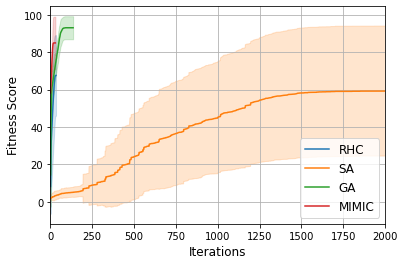

In [30]:
show_iterations('4peaks-50.pkl')
plt.xlim([0, 2000])
plt.savefig('fp-summ.pdf')

In [42]:
res = load_model('li-64.pkl')
df = resource_report(res)
#df = df.drop(columns=['Std Time', 'Std Evals', 'Std Iters'])
df.to_latex('li-res.tex', float_format='{:.1f}'.format)
df

,Mean Time,Std Time,Mean Evals,Std Evals,Mean Iters,Std Iters
RHC,1.175042,0.047475,17294.64,709.855697,272.04,10.755389
SA,0.130998,0.014717,1246.58,94.053621,947.90,65.501221
GA,2.994109,1.109430,19941.58,4278.074095,98.12,21.278759
MIMIC,6.599131,1.462893,30891.82,468.100574,60.64,0.932952


In [38]:
summary_scores(res)

,mean,std,min,25 pct,50 pct,75 pct,max
RHC,33.254831,3.853652,24.192008,30.313965,33.043921,36.141737,39.883027
SA,20.342634,7.102905,5.301438,16.120482,20.669211,25.803094,35.947526
GA,34.867313,3.857005,24.611882,32.875606,35.553199,37.200363,39.883027
MIMIC,39.803960,0.230717,38.724806,39.883027,39.883027,39.883027,39.883027


In [18]:
ranks(res)

,1,2,3,4
RHC,3,15,31,1
SA,0,1,2,47
GA,10,22,16,2
MIMIC,49,1,0,0


In [45]:
res = load_model('4peaks-50.pkl')
df = resource_report(res)
#df = df.drop(columns=['Std Time', 'Std Evals', 'Std Iters'])
df.to_latex('4peaks-res.tex', float_format='{:.1f}'.format)
df

,Mean Time,Std Time,Mean Evals,Std Evals,Mean Iters,Std Iters
RHC,0.157261,0.038172,9338.16,2243.824765,199.58,43.150476
SA,0.077281,0.024762,2374.68,673.997758,1662.78,562.874383
GA,2.288436,0.220813,22840.52,2035.294281,112.54,10.117727
MIMIC,3.258401,0.828417,70353.22,18121.788339,22.44,6.037085


In [21]:
summary_scores(res)

,mean,std,min,25 pct,50 pct,75 pct,max
RHC,67.60,21.555510,50.0,50.00,50.0,94.0,94.0
SA,59.46,34.754113,5.0,50.00,50.0,94.0,94.0
GA,93.12,6.160000,50.0,94.00,94.0,94.0,94.0
MIMIC,85.00,14.025691,58.0,75.25,94.0,94.0,94.0


In [31]:
ranks(res)

,1,2,3,4
RHC,20,0,17,13
SA,22,0,9,19
GA,49,0,1,0
MIMIC,32,8,8,2


In [44]:
res = load_model('tr-30.pkl')
df = resource_report(res)
#df = df.drop(columns=['Std Time', 'Std Evals', 'Std Iters'])
df.to_latex('tr-res.tex', float_format='{:.1f}'.format)
df

,Mean Time,Std Time,Mean Evals,Std Evals,Mean Iters,Std Iters
RHC,0.137435,0.004626,9300.48,290.320254,310.64,9.072508
SA,0.003405,0.000570,76.32,12.736467,60.08,11.331090
GA,0.350351,0.023802,4210.80,266.348569,19.92,1.324236
MIMIC,0.106274,0.013226,1860.30,153.951583,8.24,0.763151


In [35]:
ranks(res)

,1,2,3,4
RHC,50,0,0,0
SA,49,1,0,0
GA,0,0,47,3
MIMIC,0,0,48,2


In [36]:
summary_scores(res)

,mean,std,min,25 pct,50 pct,75 pct,max
RHC,100.000000,0.000000,100.000000,100.0,100.0,100.0,100.000000
SA,99.833333,1.166667,91.666667,100.0,100.0,100.0,100.000000
GA,70.000000,0.000000,70.000000,70.0,70.0,70.0,70.000000
MIMIC,70.811111,4.055495,66.111111,70.0,70.0,70.0,91.666667


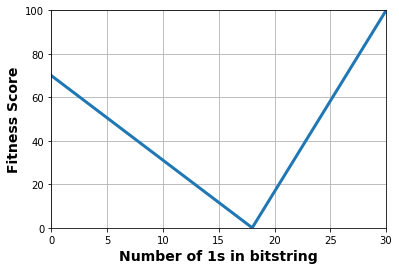

In [23]:
# Unitation Chart

u = np.arange(0, 31)
c = 18
N = 30

score = np.where(u<=c, 70/c*(c-u), 100/(N-c)*(u-c))
plt.figure()
plt.plot(u, score, linewidth=3)
plt.grid()
plt.ylim([0,100])
plt.xlim([0, 30])
plt.xlabel('Number of 1s in bitstring', fontweight='bold', fontsize=14)
plt.ylabel('Fitness Score', fontweight='bold', fontsize=14)
plt.savefig('tr-fitness.pdf')
